In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Burgers' equation 

We want to solve the non-linear equation:

$\displaystyle\frac{\partial u}{\partial t} + u \displaystyle\frac{\partial u}{\partial x}=0$,

## Second order solver with fluxes

We will now follow the second order method outlined in Chapter 5, and modify our previous code. The only thing we really have to modify is the determination of the fluxes at the edges and the Riemann solver. The rest of the scheme will remain unchanged. We could use flux limiters, if we wanted.

### Code

We write down routines to create the grid, set the boundary conditions and initialize the state separately. The boundary conditions will be slightly different because they now are Neumann type.

In [2]:
def create_grid(n,dx):
    return np.arange(n)*dx

In [3]:
def set_neumann_bc(mm):
    mm[0]=mm[1]
    mm[-1]=mm[-2]
    return mm

In [4]:
def initialize_state_jump(n,x,dx):
    m=np.ones(n)
    il=int(.5/dx)
    m[il:]=2.
    return m

In [5]:
def initialize_state_sinusoid(n,x,dx):
    m=np.ones(n)
    il=int(.333/dx)
    ir=int(.666/dx)
    m[il:ir]=1.+0.5*np.sin(2.*np.pi*(x[il:ir]-0.333)*3.)
    return m

In [6]:
def calculate_timestep(u,dx,C=0.999):
    return np.min(dx*C/np.abs(u))

To calculate the 'left' state, we will follow Eq. (6.7) for $\partial_x u$

In [7]:
def calculate_uL(u,dt,dx):
    du=(np.roll(u,-1)-np.roll(u,1))/(2.*dx)
    du[0]=0.; du[-1]=0.;
    return u[:-1]+dx/2.*(1.-u[:-1]*dt/dx)*du[:-1]

To calculate the 'right' state, we will follow Eq. (5.7) and (5.8) for $\partial_x u$ and substitute for $u$

In [8]:
def calculate_uR(u,dt,dx):
    du=(np.roll(u,-1)-np.roll(u,1))/(2.*dx)
    du[0]=0.; du[-1]=0.;
    return u[1:]-dx/2.*(1.+u[1:]*dt/dx)*du[1:]

We solve the Riemann problem according to (6.14-15)

In [9]:
def solve_Riemann(uL,uR,u):
    nx=len(uL)
    us=np.zeros(nx)
    for i in range(nx):
        fr=u[i+1]*u[i+1]/2.
        fl=u[i]*u[i]/2.
        if (u[i]>u[i+1]):  #Shock
            s=(fr-fl)/(u[i+1]-u[i])
            if s > 0:
                us[i]=uL[i]
            elif s < 0:
                us[i]=uR[i]
        else:
            if u[i]>0:
                us[i]=uL[i]
            elif u[i+1]<0:
                us[i]=uR[i]
                
    flux=0.5*us*us
            
    return flux

We will run the equation between $t_0=0$ and $t_\max=5$, and set $u=1$. We will set periodic boundary conditions at $x=0$ and $x=1$. All of this means that our initial solution will have travelled by $u t_\max=5$, and because the solution is periodic with a periodicity length one, the exact solution at $t=t_\max$ is the same as the initial condition. 

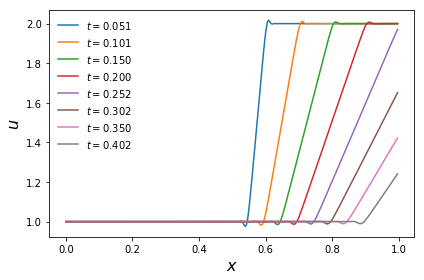

In [10]:
t0=0.; tmax=0.4;
nx=256; u=1;
xmin=0.; xmax=1.
dx=(xmax-xmin)/(nx)
x=create_grid(nx+1,dx)
u0=initialize_state_jump(nx+1,x,dx)
u0=set_neumann_bc(u0)
C=.8
t=t0
u=u0.copy()
tplot=0.05
while t < tmax:
    dt=calculate_timestep(u,dx,C)
    uL=calculate_uL(u,dt,dx)
    uR=calculate_uR(u,dt,dx)
    flux=solve_Riemann(uL,uR,u)
    u[1:-1]=u[1:-1]-dt/dx*(np.roll(flux,-1)-flux)[:-1]
    u=set_neumann_bc(u) 
      
    t += dt
            
    if(np.remainder(t,tplot) < dt):
        plt.plot(x[:nx], u[:nx], label="$t = %5.3f$" % (t))
            

plt.xlabel("$x$", fontsize=16)
plt.ylabel("$u$", fontsize=16)
plt.legend(frameon=False, loc="best")
plt.tight_layout()
plt.show()

### Min-mod Flux limiter 

As we can see,the second order code now generates new maxima and minima. To solve these, we have to implement a flux limiter. Because we modularized our code, the only thing we have to change is the calculation of $\partial_x u$ in the calculation of the left and right interfaces.

We will implement the min-mod flux limiter as detailed in Equations (5.11) and (5.12)

In [11]:
def calculate_uL_minmod(u,C,dx):
    nx=len(u)    
    du=np.zeros(nx)
    for i in range(nx-1):
        amm=(u[i]-u[i-1])/dx
        bmm=(u[i+1]-u[i])/dx
        if((abs(bmm)<abs(amm)) and amm*bmm > 0.):
            du[i]=bmm
        elif ((abs(amm)<abs(bmm)) and amm*bmm > 0.):
            du[i]=amm
    du[0]=0.; du[-1]=0.;
    return u[:-1]+dx/2.*(1.-u[:-1]*dt/dx)*du[:-1]

In [12]:
def calculate_uR_minmod(a,C,dx):
    nx=len(u)
    du=np.zeros(nx)
    for i in range(nx-1):
        amm=(u[i]-u[i-1])/dx
        bmm=(u[i+1]-u[i])/dx
        if((abs(bmm)<abs(amm)) and amm*bmm > 0.):
            du[i]=bmm
        elif ((abs(amm)<abs(bmm)) and amm*bmm > 0.):
            du[i]=amm
    du[-1]=du[0]
    return u[1:]-dx/2.*(1.+u[1:]*dt/dx)*du[1:]

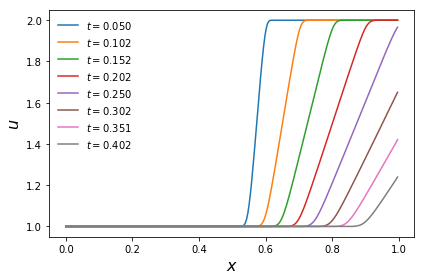

In [14]:
t0=0.; tmax=0.4;
nx=256; u=1;
xmin=0.; xmax=1.
dx=(xmax-xmin)/(nx)
x=create_grid(nx+1,dx)
u0=initialize_state_jump(nx+1,x,dx)
u0=set_neumann_bc(u0)
C=.8
t=t0
u=u0.copy()
tplot=0.05
while t < tmax:
    dt=calculate_timestep(u,dx,C)
    uL=calculate_uL_minmod(u,dt,dx)
    uR=calculate_uR_minmod(u,dt,dx)
    flux=solve_Riemann(uL,uR,u)
    u[1:-1]=u[1:-1]-dt/dx*(np.roll(flux,-1)-flux)[:-1]
    u=set_neumann_bc(u) 
      
    t += dt
            
    if(np.remainder(t,tplot) < dt):
        plt.plot(x[:nx], u[:nx], label="$t = %5.3f$" % (t))
            

plt.xlabel("$x$", fontsize=16)
plt.ylabel("$u$", fontsize=16)
plt.legend(frameon=False, loc="best")
plt.tight_layout()
plt.show()

We have completely removed oscillations from the final solution.

## Sinusoid initial conditions

Finally, let us try sinusoid initial conditions (Fig 6.5)

First, with no flux limiter. This initial condition will lead to the formation of a shock.

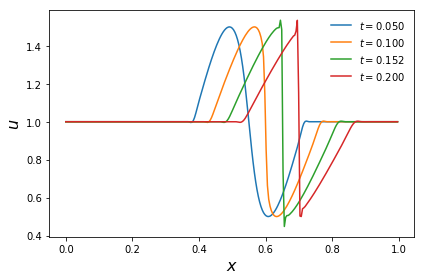

In [15]:
t0=0.; tmax=0.2;
nx=256; u=1;
xmin=0.; xmax=1.
dx=(xmax-xmin)/(nx)
x=create_grid(nx+1,dx)
u0=initialize_state_sinusoid(nx+1,x,dx)
u0=set_neumann_bc(u0)
C=.8
t=t0
u=u0.copy()
tplot=0.05
while t < tmax:
    dt=calculate_timestep(u,dx,C)
    uL=calculate_uL(u,dt,dx)
    uR=calculate_uR(u,dt,dx)
    flux=solve_Riemann(uL,uR,u)
    u[1:-1]=u[1:-1]-dt/dx*(np.roll(flux,-1)-flux)[:-1]
    u=set_neumann_bc(u) 
      
    t += dt
            
    if(np.remainder(t,tplot) < dt):
        plt.plot(x[:nx], u[:nx], label="$t = %5.3f$" % (t))
            

plt.xlabel("$x$", fontsize=16)
plt.ylabel("$u$", fontsize=16)
plt.legend(frameon=False, loc="best")
plt.tight_layout()
plt.show()

Now, with a flux limiter, we can see how the oscillations round the shock are removed.

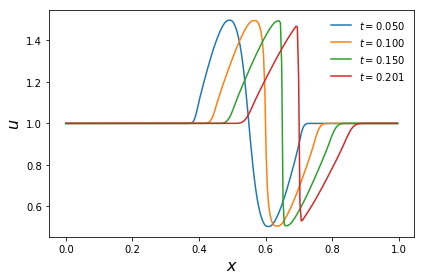

In [17]:
t0=0.; tmax=0.2;
nx=256; u=1;
xmin=0.; xmax=1.
dx=(xmax-xmin)/(nx)
x=create_grid(nx+1,dx)
u0=initialize_state_sinusoid(nx+1,x,dx)
u0=set_neumann_bc(u0)
C=.8
t=t0
u=u0.copy()
tplot=0.05
while t < tmax:
    dt=calculate_timestep(u,dx,C)
    uL=calculate_uL_minmod(u,dt,dx)
    uR=calculate_uR_minmod(u,dt,dx)
    flux=solve_Riemann(uL,uR,u)
    u[1:-1]=u[1:-1]-dt/dx*(np.roll(flux,-1)-flux)[:-1]
    u=set_neumann_bc(u) 
      
    t += dt
            
    if(np.remainder(t,tplot) < dt):
        plt.plot(x[:nx], u[:nx], label="$t = %5.3f$" % (t))
            

plt.xlabel("$x$", fontsize=16)
plt.ylabel("$u$", fontsize=16)
plt.legend(frameon=False, loc="best")
plt.tight_layout()
plt.show()